In [2]:
import networkx as nx
import itertools
import more_itertools
import pandas

pandas.set_option('display.max_columns', None)  # or 1000
pandas.set_option('display.max_rows', None)  # or 1000
pandas.set_option('display.max_colwidth', None)  # or 199

In [3]:
oracles = nx.read_edgelist('oracles', create_using=nx.DiGraph)
implications = nx.read_edgelist('implications', create_using=nx.DiGraph)

def closed_descendants(x):
    return {x} | nx.descendants(implications, x)

def closed_ancestors(x):
    return {x} | nx.ancestors(implications, x)

In [4]:
oracle_set = set()

for (a, b) in oracles.edges:
    if b in nx.descendants(implications, a):
        print(a,b)
    
    s = set(itertools.product({a} | nx.descendants(implications, a), {b} | nx.ancestors(implications, b)))
    oracle_set = oracle_set | s

In [5]:
missing_oracles = nx.complement(nx.transitive_closure(implications))
missing_oracles.remove_edges_from(oracle_set)

df = pandas.DataFrame(missing_oracles.edges, columns=['A', 'B'])
df['Q-Q\'-Question'] = df.apply(lambda x: 'neqQ' in closed_descendants(x.A) and 'neqQ\'' in closed_ancestors(x.B), axis='columns')
df['TFNP-DisjCoNP-Question'] = df.apply(lambda x: 'TFNP' in closed_descendants(x.A) and 'DisjCoNP' in closed_ancestors(x.B), axis='columns')
df['UP-DisjNP-Question'] = df.apply(lambda x: 'UP' in closed_descendants(x.A) and 'DisjNP' in closed_ancestors(x.B), axis='columns')


selected = df 
#selected = selected[selected.apply(lambda x: all(y not in {'DisjNPinsep', 'UPcapCoUPneqP'} for y in [x.A, x.B]), axis='columns')]
selected.sort_values(by=list(set(df.columns) - {'A', 'B'}))

,A,B,Q-Q'-Question,TFNP-DisjCoNP-Question,UP-DisjNP-Question
0,CONN,DisjNPinsep,False,False,False
1,TAUT,CONN,False,False,False
2,TAUT,DisjNPinsep,False,False,False
3,TAUT,NPneqCoNP,False,False,False
4,NPneqCoNP,TAUTorSAT,False,False,False
8,NPMVtnotcontainedinTFNP,negQ',False,False,False
9,negQ,negQ',False,False,False
10,negQ,NPMVtnotcontainedinTFNP,False,False,False
11,NPcapCoNP,NPneqCoNP,False,False,False
15,NPMVt,negQ',False,False,False


In [6]:
oracle_graph = nx.DiGraph()
oracle_graph.add_nodes_from(missing_oracles.edges)
for o1, o2 in itertools.permutations(oracle_graph.nodes, 2):
    a1, b1 = o1
    a2, b2 = o2
    if a2 in closed_descendants(a1) and b2 in closed_ancestors(b1):
        oracle_graph.add_edge(o1, o2)

In [7]:
for c in nx.weakly_connected_components(oracle_graph):
    sorted_c = nx.topological_sort(oracle_graph.subgraph(c))
    ret = []
    for oracle in sorted_c:
        if oracle_graph.subgraph(c).out_degree(oracle) == 0:
            ret.append((oracle, len(nx.ancestors(oracle_graph.subgraph(c), oracle))))
    print(ret)

[(('TAUT', 'DisjNPinsep'), 1)]
[(('UP', 'DisjNP'), 2), (('TAUT', 'CONN'), 3)]
[(('NPneqCoNP', 'TAUTorSAT'), 0)]
[(('NPMVt', 'DisjCoNP'), 6), (('negQ', "negQ'"), 8)]
[(('NPcapCoNP', 'NPneqCoNP'), 0)]


In [8]:
hard = [('negQ', "negQ'"), ('NPMVt', 'DisjCoNP'), ('UP', 'DisjNP')]

for n in oracle_graph.nodes:
    if n in hard or any(x in nx.descendants(oracle_graph, n) for x in hard):
        oracle_graph.nodes[n]['fillcolor'] = 'red'
    oracle_graph.nodes[n]['style'] = 'filled'

for a, b in oracle_graph.nodes:
    oracle_graph.nodes[(a,b)]['label'] = f'{a} ⇏ {b}'.replace('insep', ' insep').replace('notcontainedin', ' ⊈c ').replace('neq', '≠').replace('neg', '¬')

nx.drawing.nx_pydot.write_dot(oracle_graph, 'oracle_graph.dot')

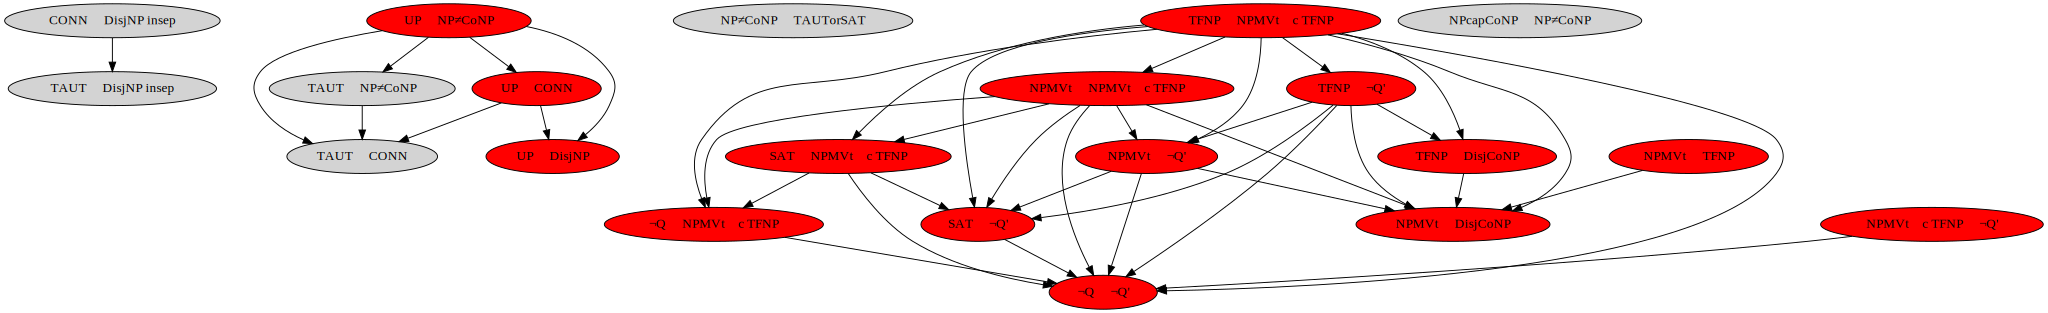

In [9]:
from IPython.core.display import SVG, display

def draw(graph):
    svg = nx.nx_agraph.to_agraph(graph).draw(prog='dot',format='svg')
    display(SVG(svg))
    
draw(oracle_graph)

## Existenz von Orakeln mit $\geq 2$ Aussagen

In [10]:
hyp = ['DisjNP', 'DisjCoNP', 'UP', 'negQ']
df = pandas.DataFrame(itertools.product([False, True], repeat=len(hyp)), columns=hyp)
copy = df.copy()

df['oracle'] = ''
df.loc[copy['DisjCoNP']&~copy['negQ'], 'oracle'] = 'inconsistent'


df.loc[copy['DisjCoNP']&copy['negQ'], 'negQ'] = '(True)'
df.loc[~copy['DisjCoNP']&~copy['negQ'], 'DisjCoNP'] = '(False)'


print(df.astype(str).apply(lambda x: x.str.replace('True', '$+$').str.replace('False', '$-$')).to_latex(escape=False))

\begin{tabular}{llllll}
\toprule
{} & DisjNP & DisjCoNP &   UP &   negQ &        oracle \\
\midrule
0  &    $-$ &    ($-$) &  $-$ &    $-$ &               \\
1  &    $-$ &      $-$ &  $-$ &    $+$ &               \\
2  &    $-$ &    ($-$) &  $+$ &    $-$ &               \\
3  &    $-$ &      $-$ &  $+$ &    $+$ &               \\
4  &    $-$ &      $+$ &  $-$ &    $-$ &  inconsistent \\
5  &    $-$ &      $+$ &  $-$ &  ($+$) &               \\
6  &    $-$ &      $+$ &  $+$ &    $-$ &  inconsistent \\
7  &    $-$ &      $+$ &  $+$ &  ($+$) &               \\
8  &    $+$ &    ($-$) &  $-$ &    $-$ &               \\
9  &    $+$ &      $-$ &  $-$ &    $+$ &               \\
10 &    $+$ &    ($-$) &  $+$ &    $-$ &               \\
11 &    $+$ &      $-$ &  $+$ &    $+$ &               \\
12 &    $+$ &      $+$ &  $-$ &    $-$ &  inconsistent \\
13 &    $+$ &      $+$ &  $-$ &  ($+$) &               \\
14 &    $+$ &      $+$ &  $+$ &    $-$ &  inconsistent \\
15 &    $+$ &      $+$ &  $+$ 